[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kmani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                           statement        label
0  Says the Annies List political group supports ...        false
1  When did the decline of coal start? It started...    half-true
2  Hillary Clinton agrees with John McCain "by vo...  mostly-true
3  Health care reform legislation is likely to ma...        false
4  The economic turnaround started at the end of ...    half-true
0    says annies list political group supports thir...
1    decline coal start started natural gas took st...
2    hillary clinton agrees john mccain voting give...
3    health care reform legislation likely mandate ...
4                 economic turnaround started end term
Name: clean_statement, dtype: object
(10240, 5000)
(10240,)
(8192, 5000) (2048, 5000)
Accuracy: 0.60107421875
              precision    recall  f1-score   support

           0       0.55      0.43      0.48       888
           1       0.63      0.73      0.68      1160

    accuracy                           0.60      2048
 

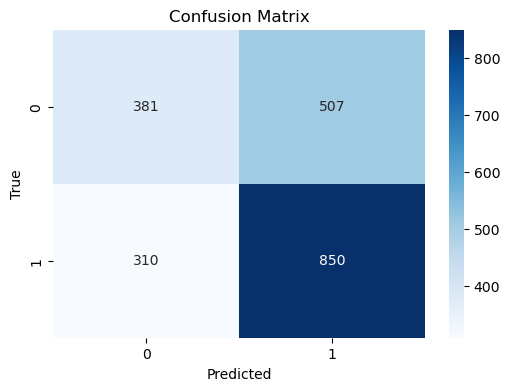

Model and vectorizer saved!


In [1]:
import pandas as pd
import zipfile
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  # Import joblib for saving models

# Unzip the file
with zipfile.ZipFile('liar_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('liar_dataset')

# Load the training data
train_df = pd.read_csv('liar_dataset/train.tsv', sep='\t', header=None)

# Assign meaningful column names based on LIAR dataset documentation
train_df.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title', 
                    'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 
                    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Show a few samples
print(train_df[['statement', 'label']].head())

# Data Preprocessing 
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply cleaning
train_df['clean_statement'] = train_df['statement'].apply(clean_text)

# Preview
print(train_df['clean_statement'].head())

# Feature extraction

# Define TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the cleaned statements
X = vectorizer.fit_transform(train_df['clean_statement'])

# Labels: map LIAR's multi-class into binary (optional)
label_map = {
    'pants-fire': 0,
    'false': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'true': 1
}

y = train_df['label'].map(label_map)

# Final feature and label sets
print(X.shape)
print(y.shape)

# Train-test the ML model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

# Train the ML model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Save the model and vectorizer

# Save the model to a file
joblib.dump(model, 'fake_news_model.pkl')

# Save the vectorizer to a file
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print("Model and vectorizer saved!")


In [2]:
import threading
from flask import Flask, request, render_template
import joblib
import re
from nltk.corpus import stopwords

# Load the trained model and vectorizer
model = joblib.load('fake_news_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Initialize the Flask app
app = Flask(__name__)

# Preprocessing function
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Define the prediction route
@app.route('/', methods=['GET', 'POST'])
def index():
    prediction = ""
    if request.method == 'POST':
        # Get the content from the user
        user_input = request.form['content']
        
        # Clean the input text
        clean_input = clean_text(user_input)
        
        # Vectorize the input text
        input_vector = vectorizer.transform([clean_input])
        
        # Predict using the model
        result = model.predict(input_vector)
        
        # Map prediction back to text
        prediction = 'Real' if result[0] == 1 else 'Fake'

    return render_template('index.html', prediction=prediction)

# Function to run the Flask app
def run_flask():
    app.run(debug=True, use_reloader=False)  # Disable reloader when running in Jupyter

# Run Flask in a separate thread
flask_thread = threading.Thread(target=run_flask)
flask_thread.start()


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
